## 以下のモデルのアンサンブル

- ~~efficient net v1 b0(512 x 512) => 回転あり and focal loss~~
- ~~efficient net v2 b3(768 x 768) => 回転あり and focal loss~~
- efficient net v2 L (448 x 448) => 回転あり elastic cos +
- ~~swin transformer v2 small(224 x 224) => 回転あり and focal loss~~
- ~~conv next nano(768 x 768) => 回転あり and focal loss~~
- conv next large(448 x 448) => 回転あり elastic cos +
- nfnet l0(768 x 768) => 回転あり
- **focalnet(768 x 768) => 回転あり and focal loss => 重み0.8**
- ~~coatnet => 回転あり and focal loss~~
- ~~maxvit(512 x 512) => 回転あり and focal loss~~
- carformer(448 x 448) => 回転あり elastic cos +
- convformer(384 x 384) => 回転あり elastic cos +

In [1]:
import gc

import pandas as pd
import numpy as np
from joblib import load

from src.emsamble import emsamble_features
from src.const import OUTPUT_ROOT, QUERY_IMAGES_PATH, CITE_IMAGES_PATH
from src.data_handler import load_trainable_df
from src.searcher import SimilaritySearcher

In [2]:
DST = OUTPUT_ROOT / 'post_process' / 'submissions' / 'nfnet_768-convnext_large-efficientnetv2_large-carformer-convformer-focalnet0_8.csv'
DST.parent.mkdir(parents=True, exist_ok=True)

In [3]:
TARGET_ROOT_PATH_AND_WEIGHTS_LIST = [
    # (
    #     OUTPUT_ROOT / 'train_arcface_with_label_smoothing' / 'outputs' / 'convnextv2_nano_apply_rotate' / 'predictions',
    #     1
    # ),
    (
        OUTPUT_ROOT / 'google_colabo' / 'convnext_v2_large',
        1
    ),
    (
        OUTPUT_ROOT / 'google_colabo' / 'efficientnetv2_l',
        1
    ),
    # (
    #     OUTPUT_ROOT / 'train_arcface_with_label_smoothing' / 'outputs' / 'swinv2_small_apply_rotate' / 'predictions',
    #     1
    # ),
    # (
    #     OUTPUT_ROOT / 'train_arcface_with_label_smoothing' / 'outputs' / 'effnetv2_b3_apply_rotate' / 'predictions',
    #     1
    # ),
    # (
    #     OUTPUT_ROOT / 'train_arcface_with_label_smoothing' / 'outputs' / 'effnetb0_apply_rotate_and_focal_loss' / 'predictions',
    #     1
    # ),
    (
        OUTPUT_ROOT / 'train_arcface_with_label_smoothing' / 'outputs' / 'NENet_L0_768_rotate' / 'predictions',
        1
    ),
    # (
    #     OUTPUT_ROOT / 'train_arcface_with_label_smoothing' / 'outputs' / 'coatnet_apply_rotate' / 'predictions',
    #     0.8
    # ),
    (
        OUTPUT_ROOT / 'train_arcface_with_label_smoothing' / 'outputs' / 'focalnet_lrf_apply_rotate' / 'predictions',
        0.8
    ),
    # (
    #     OUTPUT_ROOT / 'train_arcface_with_label_smoothing' / 'outputs' / 'maxvit' / 'predictions',
    #     0.8
    # ),
    (
        OUTPUT_ROOT / 'train_elastic_cos' / 'outputs' / 'caformer' / 'predictions',
        1
    ),
    (
        OUTPUT_ROOT / 'train_elastic_cos' / 'outputs' / 'convformer' / 'predictions',
        1
    ),
    (
        OUTPUT_ROOT / 'train_elastic_cos' / 'outputs' / 'iformer' / 'predictions',
        0.8
    )
]

In [4]:
cite_emsamble = []
test_emsamble = []
for (target_root, weight) in TARGET_ROOT_PATH_AND_WEIGHTS_LIST:
    print(target_root)
    cite_embeddings = np.mean(
        load(target_root / 'cite_embeddings.pkl')['embeddings_list'],
        axis=0
    )
    test_embeddings = np.mean(
        load(target_root / 'test_embeddings.pkl')['embeddings_list'],
        axis=0
    )
    cite_emsamble.append((cite_embeddings, weight))
    test_emsamble.append((test_embeddings, weight))
del cite_embeddings, test_embeddings
gc.collect()

/work/output/google_colabo/convnext_v2_large
/work/output/google_colabo/efficientnetv2_l
/work/output/train_arcface_with_label_smoothing/outputs/NENet_L0_768_rotate/predictions
/work/output/train_arcface_with_label_smoothing/outputs/focalnet_lrf_apply_rotate/predictions
/work/output/train_elastic_cos/outputs/caformer/predictions
/work/output/train_elastic_cos/outputs/convformer/predictions
/work/output/train_elastic_cos/outputs/iformer/predictions


0

In [5]:
cite_emsamble = emsamble_features(cite_emsamble)
test_emsamble = emsamble_features(test_emsamble)

In [6]:
searcher = SimilaritySearcher(cite_emsamble.astype(np.float32))
D, I = searcher.search(test_emsamble.astype(np.float32), k=20)

## Make submission

In [7]:
(_, test_df, cite_df, sample_submission_df) = load_trainable_df()
IDX2CITE_GID = cite_df.to_dict()["gid"]

In [8]:
def make_submission(indices):
    vfunc = np.vectorize(lambda x: IDX2CITE_GID[x])
    gid_array = vfunc(I)
    submission_df = test_df[["gid"]].assign(cite_gid=[" ".join(list(x)) for x in gid_array.astype(str)])
    return submission_df

In [9]:
submission_df = make_submission(indices=I)
submission_df.to_csv(DST, index=False)

In [10]:
submission_df = pd.read_csv(DST)

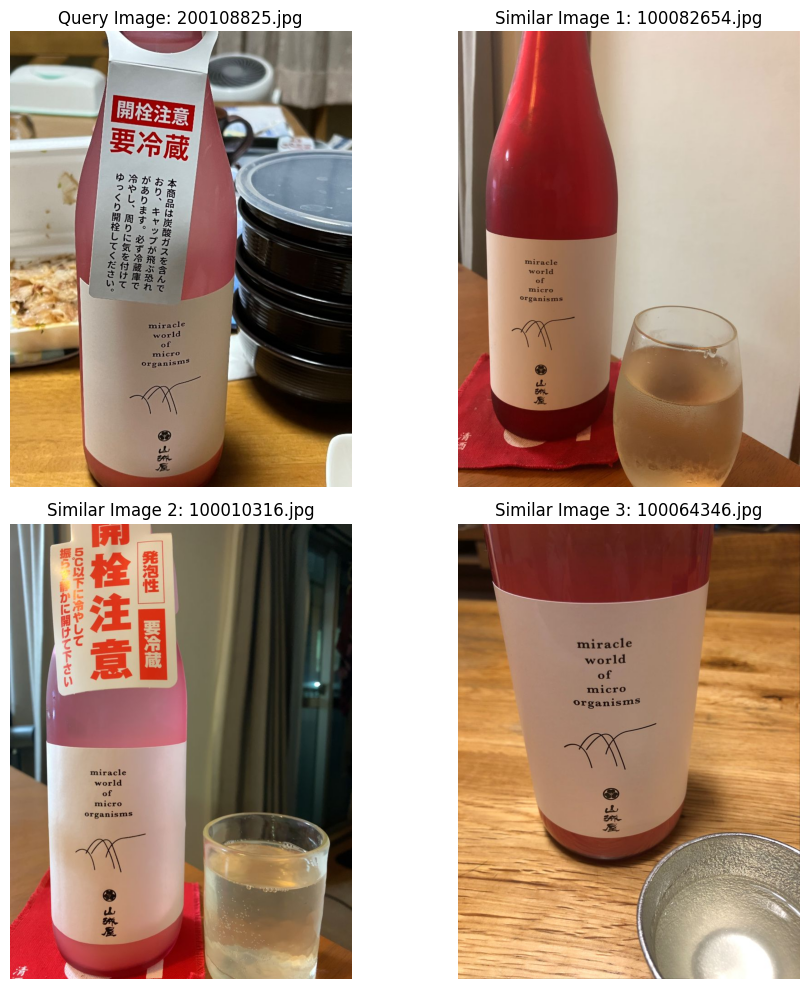

In [18]:
import cv2
import matplotlib.pyplot as plt

def display_similar_images(query_path, cite_paths):
    num_similar = len(cite_paths)

    # Query画像の読み込み
    query_image = cv2.imread(query_path)
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)

    # 類似画像の読み込みと表示
    num_rows = (num_similar + 1) // 2
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, 10), squeeze=False)

    axs[0, 0].imshow(query_image)
    axs[0, 0].set_title(f'Query Image: {query_path.split("/")[-1]}')
    axs[0, 0].axis('off')

    for i, path in enumerate(cite_paths):
        similar_image = cv2.imread(path)
        similar_image = cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB)

        axs[(i+1)//2, (i+1)%2].imshow(similar_image)
        axs[(i+1)//2, (i+1)%2].set_title(f'Similar Image {i+1}: {path.split("/")[-1]}')
        axs[(i+1)//2, (i+1)%2].axis('off')

    # 空白のsubplotを削除
    if num_similar % 2 != 0:
        axs[num_rows-1, 1].axis('off')

    plt.tight_layout()
    plt.show()


def get_qyery_and_cite_path(submission_df, query_gid=None, k=4):
    if query_gid is None:
        query_gid = submission_df["gid"].sample(1).to_numpy()[0]

    cites = submission_df.loc[submission_df["gid"] ==query_gid, "cite_gid"].to_numpy()[0].split(" ")[:k]

    query_path = QUERY_IMAGES_PATH / f"{query_gid}.jpg"
    cite_paths = [(CITE_IMAGES_PATH / f"{cite_gid}.jpg").as_posix() for cite_gid in cites]
    return {"query_path":query_path.as_posix(), "cite_paths":cite_paths}


def plot_sake(submission_df, query_gid=None, k=11):
    path_dict = get_qyery_and_cite_path(submission_df, query_gid=query_gid, k=k)
    display_similar_images(**path_dict)


# plot_sake(submission_df, query_gid=200108186, k=3)
# plot_sake(submission_df, query_gid=200109632, k=3)
# plot_sake(submission_df, query_gid=200108968, k=3)
# plot_sake(submission_df, query_gid=200109144, k=3)
# plot_sake(submission_df, query_gid=200110763, k=11)
plot_sake(submission_df, query_gid=None, k=3)